In [1]:
import numpy as np
import random

from tenpy.networks.mps import MPS
from tenpy.models.model import CouplingMPOModel#, NearestNeighborModel
#from tenpy.lattice import Chain
#from ..tools.params import asConfig
from tenpy.networks.site import BosonSite#, SpinHalfFermionSite
from tenpy.algorithms import dmrg

import matplotlib.pyplot as plt
#__all__ = ['BoseHubbardModel', 'BoseHubbardChain', 'FermiHubbardModel', 'FermiHubbardChain']

random.seed(1234)

### Functions:

In [53]:
class myModel(CouplingMPOModel):
    r"""Spinless Bose-Hubbard model.
    The Hamiltonian is:
    .. math ::
        H = - t \sum_{\langle i, j \rangle, i < j} (b_i^{\dagger} b_j + b_j^{\dagger} b_i)
            + V \sum_{\langle i, j \rangle, i < j} n_i n_j
            + \frac{U}{2} \sum_i n_i (n_i - 1) - \mu \sum_i n_i
    Here, :math:`\langle i,j \rangle, i< j` denotes nearest neighbor pairs.
    All parameters are collected in a single dictionary `model_params`, which
    is turned into a :class:`~tenpy.tools.params.Config` object.
    Parameters
    ----------
    model_params : :class:`~tenpy.tools.params.Config`
        Parameters for the model. See :cfg:config:`BoseHubbardModel` below.
    Options
    -------
    .. cfg:config :: BoseHubbardModel
        :include: CouplingMPOModel
        n_max : int
            Maximum number of bosons per site.
        filling : float
            Average filling.
        conserve: {'best' | 'N' | 'parity' | None}
            What should be conserved. See :class:`~tenpy.networks.Site.BosonSite`.
        t, U, V, mu: float | array
            Couplings as defined in the Hamiltonian above. Note the signs!
    """
    def init_sites(self, model_params):
        n_max = model_params.get('n_max', 0)
        filling = model_params.get('filling', 0)
        conserve = model_params.get('conserve', 'N')
        if conserve == 'best':
            conserve = 'N'
            self.logger.info("%s: set conserve to %s", self.name, conserve)
        site = BosonSite(Nmax=n_max, conserve=conserve, filling=filling)
        return site

    def init_terms(self, model_params):
        # 0) Read and set parameters.
        rc = model_params.get('rc', 0)
        t = model_params.get('t', 1.)
        U = model_params.get('U', 0.)
        V = model_params.get('V', 0.)
        mu = model_params.get('mu', 0)
#        for u in range(len(self.lat.unit_cell)):
#            self.add_onsite(-mu - U / 2., u, 'N')
#            self.add_onsite(U / 2., u, 'NN')
        for u1, u2, dx in self.lat.pairs['nearest_neighbors']:
            self.add_coupling(-t, u1, 'Bd', u2, 'B', dx, plus_hc=True)
#            self.add_coupling(V, u1, 'N', u2, 'N', dx)
        for dx in range(1,rc+1):
            self.add_coupling(V, 0, 'N', 0, 'N', dx)
#            self.add_coupling(V, 0, 'N', 0, 'N', -dx)

def structure_factor(k, psi, model_params):
    
    L = model_params.get('L', 0)
    corr_matrix = psi.correlation_function('N','N') - model_params.get('filling')**2
    res = 0 
    j = 0+1j
    for ii in range(L):
        for jj in range(L):
            res += (corr_matrix[ii,jj]/L) * np.exp(j*k*(ii-jj))
    return res

def g_2(psi, model_params):
    L = model_params.get('L', 0)
    corr_matrix = psi.correlation_function('N','N')# - model_params.get('filling')**2
    out = np.zeros(L)
    norm = np.zeros(L)
    for ii in range(L):
        for jj in range(L):
            out[abs(ii-jj)] += corr_matrix[ii,jj]
            norm[abs(ii-jj)] += 1
    return out/norm

## Tests:
***

In [54]:
L = 48
t = 1
V = 1
avg_n = 1/4
rc = 4

if (avg_n <= 1/2): 
    rho=avg_n 
else: 
    rho=1-avg_n
print('r* =', 1/rho -1)

r* = 3.0


In [55]:
model_params = dict(L=L, n_max=1, t=t, V=V, rc=rc, conserve='N', filling=avg_n, bc_MPS='finite')
M = myModel(model_params)
product_state = ['1']*int(M.lat.N_sites*avg_n) + ['vac']*int(M.lat.N_sites*(1-avg_n))
random.shuffle(product_state)
psi = MPS.from_product_state(M.lat.mps_sites(), product_state, bc=M.lat.bc_MPS)

In [56]:
psi.get_B(12,form='B').to_ndarray()

array([[[1.],
        [0.]]])

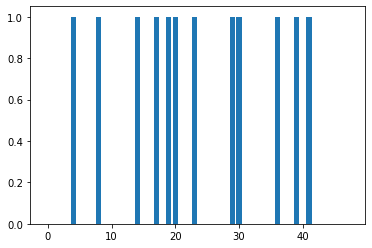

In [57]:
plt.bar(range(L), psi.expectation_value('N'))
plt.show()

In [58]:
dmrg_params = {
        'mixer': True,  # setting this to True helps to escape local minima
        'max_E_err': 1.e-10,
        'trunc_params': {
            'chi_max': 30,
            'svd_min': 1.e-10
        },
        'combine': True,
        'active_sites': 2,
        'min_sweeps' : 5#,
        #'max_sweeps' : 5
    }
info = dmrg.run(psi, M, dmrg_params)

final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=1.59e-05


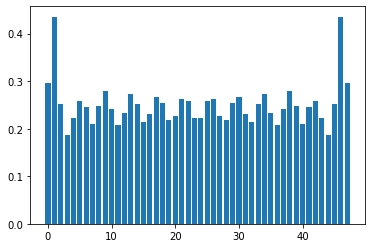

In [59]:
plt.bar(range(L), psi.expectation_value('N'))
plt.show()

In [75]:
info['sweep_statistics']

{'sweep': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31],
 'N_updates': [92,
  184,
  276,
  368,
  460,
  552,
  644,
  736,
  828,
  920,
  1012,
  1104,
  1196,
  1288,
  1380,
  1472,
  1564,
  1656,
  1748,
  1840,
  1932,
  2024,
  2116,
  2208,
  2300,
  2392,
  2484,
  2576,
  2668,
  2760,
  2852],
 'E': [24.0,
  18.0,
  13.0,
  10.0,
  7.0,
  6.0,
  4.0,
  3.0,
  3.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'S': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'max_S': [-0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,
  -0.0,

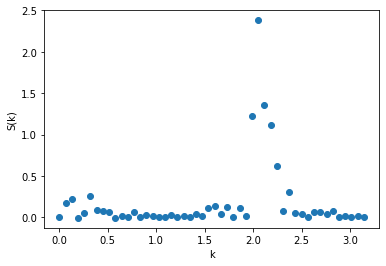

In [91]:
k = np.linspace(0,np.pi,50)

plt.figure(1)
plt.plot(k,np.real(structure_factor(k, psi, model_params)), 'o')
#plt.plot(k,np.imag(structure_factor(k, psi, model_params)), 'o')
#plt.plot(k,np.imag(structure_factor(k,correlation_matrix, model_params)), 'o')
plt.ylabel("S(k)")
plt.xlabel("k")
plt.show()

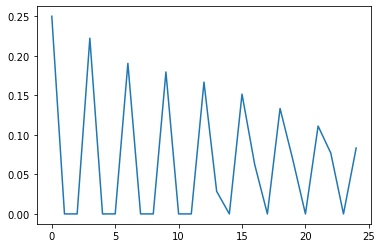

In [92]:
plt.plot(g_2(psi, model_params)[:25])

## Reproducing results w/ TenPy DMRG
***

In [92]:
## CALCULATING THE GROUND STATES for t=0
L = 48
t = 0
V = 1
avg_n = 1/4

ground_state = dict() # value -> rc, key -> (groud state, info of dmrg)

for rc in [2,3,4]:
    model_params = dict(L=L, n_max=1, t=t, V=V, rc=rc, conserve='N', filling=avg_n, bc_MPS='finite')
    M = myModel(model_params)
    product_state = ['1']*int(M.lat.N_sites*avg_n) + ['vac']*int(M.lat.N_sites*(1-avg_n))
    random.shuffle(product_state)
    psi = MPS.from_product_state(M.lat.mps_sites(), product_state, bc=M.lat.bc_MPS)
    dmrg_params = {
        'mixer': True,#dmrg.SubspaceExpansion,  # setting this to True helps to escape local minima
        'mixer_params': {
            'amplitude': 0.9,
            'decay': 1.3,
        },
        'min_sweeps': 10,
        'max_E_err': 1.e-10,
        'trunc_params': {
            'chi_max': 100,
            'svd_min': 1.e-10
        },
        'combine': True,
        'active_sites': 2
    }
    #dmrg_params = {
    #    'mixer': True,
    #    'mixer_params': {
    #        'amplitude': 1.e-3,
    #        'decay': 1.01,
    #        'disable_after': 18,
    #        },
    #    'max_sweeps': 20,
    #    'min_sweeps': 20,
    #    'chi_list': {
    #        0: 50,
    #        4: 100,
    #        8: 200,
    #       12: 400,
    #       16: 600,
    #        },
    #    'active_sites': 2
    #}
    info = dmrg.run(psi, M, dmrg_params)
    ground_state[str(rc)] = (psi.expectation_value('N'), info)

/home/lucarinna/anaconda3/lib/python3.8/site-packages/tenpy/algorithms/dmrg.py:1877: UserWarning: H is zero in the given block, nothing to diagonalize.We just return the initial state again.
  warnings.warn("H is zero in the given block, nothing to diagonalize."


In [ ]:
## CALCULATING THE MPS for V/t=6
L = 48
t = 1
V = 6
avg_n = 1/4

psi_dict = dict() # value -> rc, key -> (groud state, info of dmrg)

for rc in [2,3,4]:
    model_params = dict(L=L, n_max=1, t=t, V=V, rc=rc, conserve='N', filling=avg_n, bc_MPS='finite')
    M = myModel(model_params)
    product_state = ['1']*int(M.lat.N_sites*avg_n) + ['vac']*int(M.lat.N_sites*(1-avg_n))
    random.shuffle(product_state)
    psi = MPS.from_product_state(M.lat.mps_sites(), product_state, bc=M.lat.bc_MPS)
    dmrg_params = {
        'mixer': True,#dmrg.SubspaceExpansion,  # setting this to True helps to escape local minima
        'mixer_params': {
            'amplitude': 0.9,
            'decay': 1.3,
        },
        'min_sweeps': 5,
        'max_E_err': 1.e-10,
        'trunc_params': {
            'chi_max': 100,
            'svd_min': 1.e-10
        },
        'combine': True,
        'active_sites': 2
    }
    info = dmrg.run(psi, M, dmrg_params)
    psi_dict[str(rc)] = (psi, info)

KeyboardInterrupt: 

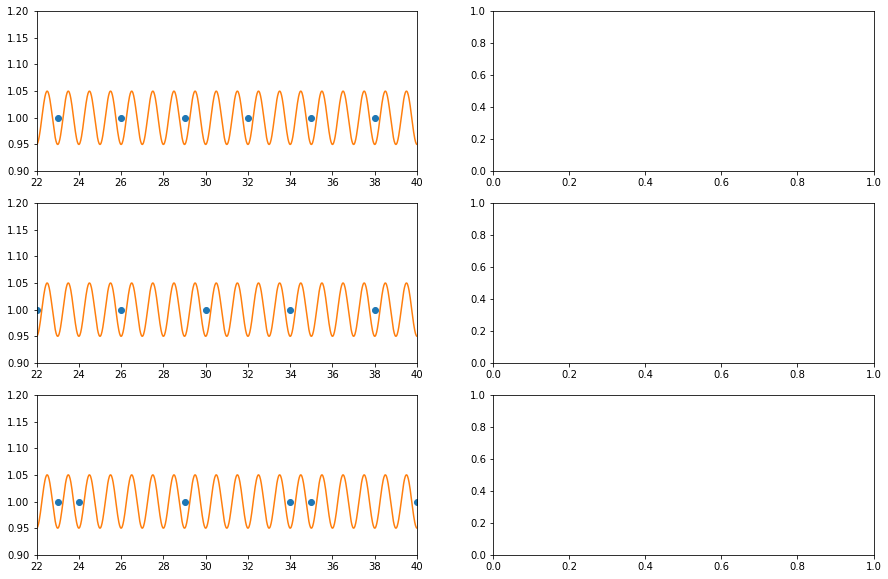

In [94]:
fig, ax = plt.subplots(3, 2, figsize=[15,10])
for count, i in enumerate([2,3,4]):
    xlim_sx = [22,40]
    x = np.linspace(xlim_sx[0],xlim_sx[1],1000)
    gs = ground_state[str(i)][0]
    mask = gs == 1
    ax[count,0].plot(np.arange(L)[mask], ground_state[str(i)][0][mask], 'o')
    ax[count,0].plot(x, 1-np.cos(x*np.pi*2)/20)
    ax[count,0].set_xlim(xlim_sx)
    ax[count,0].set_ylim(0.9,1.2)
    #ax[count,1].plot(np.arange(1,L),g_2(psi_dict[str(i)][0], model_params)[1:], '-o', markerfacecolor='none')
    #ax[count,1].set_xlim(0,25)
    #ax[count,1].set_ylim(0,0.22)
plt.show()

In [38]:
## CALCULATING THE MPS FOR rc=4 
L = 48
t = 1
rc = 4
avg_n = 1/4

ground_state_S = dict() # value -> rc, key -> (groud state, model_params, info of dmrg)

for V in [1, 3, 5]:
    model_params = dict(L=L, n_max=1, t=t, V=V, rc=rc, conserve='N', filling=avg_n, bc_MPS='finite')
    M = myModel(model_params)
    product_state = ['1']*int(M.lat.N_sites*avg_n) + ['vac']*int(M.lat.N_sites*(1-avg_n))
    random.shuffle(product_state)
    psi = MPS.from_product_state(M.lat.mps_sites(), product_state, bc=M.lat.bc_MPS)
    dmrg_params = {
        'mixer': True,#dmrg.SubspaceExpansion,  # setting this to True helps to escape local minima
        'mixer_params': {
            'amplitude': 0.9,
            'decay': 1.3,
        },
        'min_sweeps': 5,
        'max_E_err': 1.e-10,
        'trunc_params': {
            'chi_max': 100,
            'svd_min': 1.e-10
        },
        'combine': True,
        'active_sites': 2
    }
    info = dmrg.run(psi, M, dmrg_params)
    ground_state_S[str(V)] = (psi, model_params, info)

t = 0
V = 1

model_params = dict(L=L, n_max=1, t=t, V=V, rc=rc, conserve='N', filling=avg_n, bc_MPS='finite')
M = myModel(model_params)
product_state = ['1']*int(M.lat.N_sites*avg_n) + ['vac']*int(M.lat.N_sites*(1-avg_n))
random.shuffle(product_state)
psi = MPS.from_product_state(M.lat.mps_sites(), product_state, bc=M.lat.bc_MPS)
dmrg_params = {
        'mixer': True,#dmrg.SubspaceExpansion,  # setting this to True helps to escape local minima
        'mixer_params': {
            'amplitude': 0.9,
            'decay': 1.3,
        },
        'min_sweeps': 5,
        'max_E_err': 1.e-10,
        'trunc_params': {
            'chi_max': 100,
            'svd_min': 1.e-10
        },
        'combine': True,
        'active_sites': 2
}
info = dmrg.run(psi, M, dmrg_params)
ground_state_S['class'] = (psi, model_params, info)

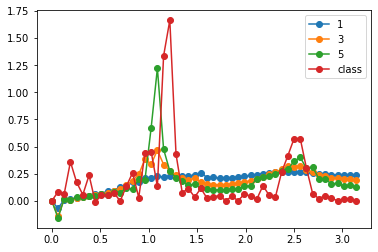

In [39]:
k = np.linspace(0,np.pi,50)
for key,val in ground_state_S.items():
    plt.plot(k,np.real(structure_factor(k, val[0], val[1])), '-o', label=key)
plt.legend()

In [27]:
ground_state_S['5'][2]['sweep_statistics']

{'sweep': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 'N_updates': [92, 184, 276, 368, 460, 552, 644, 736, 828, 920, 1012, 1104],
 'E': [445.7140681507976,
  445.54047250224085,
  445.51723215930105,
  445.51324318479857,
  445.5107580452459,
  445.5104393477442,
  445.5102653475756,
  445.5102634456622,
  445.51026014118946,
  445.5102601186445,
  445.5102600826114,
  445.51026008242263],
 'S': [0.3506254155842494,
  0.5652534352939123,
  0.6440390935337337,
  0.6938446359275536,
  0.7155982158306767,
  0.7365002952151857,
  0.7433703542960398,
  0.7449027538142537,
  0.7449516810709933,
  0.74504640240995,
  0.7450498377341023,
  0.745051475197701],
 'max_S': [0.8904515082425726,
  1.0235487282454174,
  1.059601594231084,
  1.082013553253643,
  1.1005516799910122,
  1.1243841911793981,
  1.1340356331507422,
  1.135134901840136,
  1.1352105050869419,
  1.1353693963447342,
  1.135371885575308,
  1.1353779104358974],
 'time': [1.9697620868682861,
  4.371000289916992,
  6.318036794662476,


In [429]:
0.7/(1.2**7)

0.19535715306355741

In [412]:
import tenpy
help(tenpy.algorithms.dmrg.DMRGEngine)

Help on class DMRGEngine in module tenpy.algorithms.dmrg:

class DMRGEngine(tenpy.algorithms.mps_common.Sweep)
 |  DMRGEngine(psi, model, options, **kwargs)
 |  
 |  DMRG base class with common methods for the TwoSiteDMRG and SingleSiteDMRG.
 |  
 |  This engine is implemented as a subclass of :class:`~tenpy.algorithms.mps_common.Sweep`.
 |  It contains all methods that are generic between
 |  :class:`SingleSiteDMRGEngine` and :class:`TwoSiteDMRGEngine`.
 |  Use the latter two classes for actual DMRG runs.
 |  
 |  A generic protocol for approaching a physics question using DMRG is given in
 |  :doc:`/intro/dmrg-protocol`.
 |  
 |  .. deprecated :: 0.5.0
 |      Renamed parameter/attribute `DMRG_params` to :attr:`options`.
 |  
 |  Options
 |  -------
 |  .. cfg:config :: DMRGEngine
 |      :include: Sweep
 |  
 |  Attributes
 |  ----------
 |  EffectiveH : class type
 |      Class for the effective Hamiltonian, i.e., a subclass of
 |      :class:`~tenpy.algorithms.mps_common.Effective

## Testing handwritten DMRG
***

In [47]:
class SimpleDMRGEngine_Boson:
    """DMRG algorithm, implemented as class holding the necessary data.

    Parameters
    ----------
    psi, model, chi_max, eps:
        See attributes

    Attributes
    ----------
    psi : SimpleMPS
        The current ground-state (approximation).
    model :
        The model of which the groundstate is to be calculated.
    chi_max, eps:
        Truncation parameters, see :func:`a_mps.split_truncate_theta`.
    LPs, RPs : list of np.Array[ndim=3]
        Left and right parts ("environments") of the effective Hamiltonian.
        ``LPs[i]`` is the contraction of all parts left of site `i` in the network ``<psi|H|psi>``,
        and similar ``RPs[i]`` for all parts right of site `i`.
        Each ``LPs[i]`` has legs ``vL wL* vL*``, ``RPS[i]`` has legs ``vR* wR* vR``
    """
    def __init__(self, psi, model, chi_max, eps):
        
        #assert psi.L == model.lat.mps_sites() #and psi.bc == model.bc  # ensure compatibility
        
        self.H_mpo = model.H_MPO
        self.psi = psi
        self.LPs = [None] * psi.L
        self.RPs = [None] * psi.L
        self.chi_max = chi_max
        self.eps = eps
        
        # initialize left and right environment
        D = self.H_mpo.dim[0]
        chi = psi._B[0].shape[0]
        
        LP = np.zeros([chi, D, chi], dtype=float)  # vL wL* vL*
        RP = np.zeros([chi, D, chi], dtype=float)  # vR* wR* vR
        LP[:, 0, :] = np.eye(chi)
        RP[:, D - 1, :] = np.eye(chi)
        self.LPs[0] = LP
        self.RPs[-1] = RP
        
        # initialize necessary RPs
        for i in range(psi.L - 1, 1, -1):
            self.update_RP(i)

    def sweep(self):
        
        # sweep from left to right
        for i in range(self.psi.L - 2): # 
            self.update_bond(i)
            
        # sweep from right to left
        for i in range(self.psi.L - 2, 0, -1):
            self.update_bond(i)

    def update_bond(self, i):
        
        print('u bond')
        
        j = (i + 1) % self.psi.L
        
        # get effective Hamiltonian
        Heff = SimpleHeff(self.LPs[i], self.RPs[j], 
                          self.H_mpo.get_W(i).to_ndarray(), 
                          self.H_mpo.get_W(j).to_ndarray())
        
        # Diagonalize Heff, find ground state `theta`
        theta0 = np.reshape(self.psi.get_theta(i,n=2).to_ndarray(), [Heff.shape[0]])  # initial guess
        e, v = arp.eigsh(Heff, k=1, which='SA', return_eigenvectors=True, v0=theta0)
        theta = np.reshape(v[:, 0], Heff.theta_shape)
        
        # split and truncate (SVD and truncation)
        Ai, Sj, Bj = split_truncate_theta(theta, self.chi_max, self.eps)
        
        # put back into MPS form
        Gi = np.tensordot(np.diag(self.psi.get_SL(i)**(-1)), Ai, axes=[1, 0])  # vL [vL*], [vL] i vC
        self.psi.set_B(i, npc.Array.from_ndarray_trivial(np.tensordot(Gi, np.diag(Sj), axes=[2, 0]), labels=['vL', 'p', 'vR']))  # vL i [vC], [vC*] vC
        self.psi.set_SL(i, Sj)  # vC
        self.psi.set_B(j, npc.Array.from_ndarray_trivial(Bj, labels=['vL', 'p', 'vR']))  # vC j vR
        self.update_LP(i)
        self.update_RP(j)

    def update_RP(self, i):
        
        print('u RP')
        """Calculate RP right of site `i-1` from RP right of site `i`."""
        j = (i - 1) % self.psi.L
        RP = self.RPs[i]  # vR* wR* vR
        B = self.psi.get_B(i).to_ndarray()  # vL i vR
        Bc = B.conj()  # vL* i* vR*
        W = self.H_mpo.get_W(i).to_ndarray() # wL wR i i*
        RP = np.tensordot(B, RP, axes=[2, 0])  # vL i [vR], [vR*] wR* vR
        RP = np.tensordot(RP, W, axes=[[1, 2], [3, 1]])  # vL [i] [wR*] vR, wL [wR] i [i*]
        RP = np.tensordot(RP, Bc, axes=[[1, 3], [2, 1]])  # vL [vR] wL [i], vL* [i*] [vR*]
        self.RPs[j] = RP  # vL wL vL* (== vR* wR* vR on site i-1)

    def update_LP(self, i):
        
        print('u LP')
        """Calculate LP left of site `i+1` from LP left of site `i`."""
        
        j = (i + 1) % self.psi.L
        LP = self.LPs[i]  # vL wL vL*
        B = self.psi.get_B(i).to_ndarray()  # vL i vR
        
        G = np.tensordot(np.diag(self.psi.get_SL(i)), B, axes=[1, 0])  # vL [vL*], [vL] i vR
        A = np.tensordot(G, np.diag(self.psi.get_SL(j)**-1), axes=[2, 0])  # vL i [vR], [vR*] vR
        Ac = A.conj()  # vL* i* vR*
        W = self.H_mpo.get_W(i).to_ndarray()  # wL wR i i*
        LP = np.tensordot(LP, A, axes=[2, 0])  # vL wL* [vL*], [vL] i vR
        LP = np.tensordot(W, LP, axes=[[0, 3], [1, 2]])  # [wL] wR i [i*], vL [wL*] [i] vR
        LP = np.tensordot(Ac, LP, axes=[[0, 1], [2, 1]])  # [vL*] [i*] vR*, wR [i] [vL] vR
        self.LPs[j] = LP  # vR* wR vR (== vL wL* vL* on site i+1)

import scipy.sparse
import scipy.sparse.linalg.eigen.arpack as arp
from scipy.linalg import svd

class SimpleHeff(scipy.sparse.linalg.LinearOperator):
    """Class for the effective Hamiltonian.

    To be diagonalized in `SimpleDMRGEnginge.update_bond`. Looks like this::

        .--vL*           vR*--.
        |       i*    j*      |
        |       |     |       |
        (LP)---(W1)--(W2)----(RP)
        |       |     |       |
        |       i     j       |
        .--vL             vR--.
    """
    def __init__(self, LP, RP, W1, W2):
        
        #W1 and W2 will be H_MPO[i] and H_MPO[j]
        
        self.LP = LP  # vL wL* vL*
        self.RP = RP  # vR* wR* vR
        self.W1 = W1  # wL wC i i*
        self.W2 = W2  # wC wR j j*
        
        chi1, chi2 = LP.shape[0], RP.shape[2] #vL, vR
        d1, d2 = W1.shape[2], W2.shape[2] #i, j
        
        self.theta_shape = (chi1, d1, d2, chi2)  # vL i j vR
        self.shape = (chi1 * d1 * d2 * chi2, chi1 * d1 * d2 * chi2)
        self.dtype = W1.dtype

    def _matvec(self, theta):
        """Calculate |theta'> = H_eff |theta>.

        This function is used by :func:scipy.sparse.linalg.eigen.arpack.eigsh` to diagonalize
        the effective Hamiltonian with a Lanczos method, withouth generating the full matrix."""
        
        #reshape |theta> correctly
        x = np.reshape(theta, self.theta_shape)  # vL i j vR
        
        #contract H_eff and |theta> respectively along vL* <-> vL
        x = np.tensordot(self.LP, x, axes=(2, 0))  # vL wL* [vL*], [vL] i j vR
        
        #contract H_eff and |theta> along i* <-> i, keeping wL <-> wL* contracted in H_eff
        x = np.tensordot(x, self.W1, axes=([1, 2], [0, 3]))  # vL [wL*] [i] j vR, [wL] wC i [i*]
        
        #same for w2, j <-> j*
        x = np.tensordot(x, self.W2, axes=([3, 1], [0, 3]))  # vL [j] vR [wC] i, [wC] wR j [j*]
        
        #final contraction with RP
        x = np.tensordot(x, self.RP, axes=([1, 3], [0, 1]))  # vL [vR] i [wR] j, [vR*] [wR*] vR
        
        x = np.reshape(x, self.shape[0])
        return x

def split_truncate_theta(theta, chi_max, eps):
    """Split and truncate a two-site wave function in mixed canonical form.

    Split a two-site wave function as follows::
          vL --(theta)-- vR     =>    vL --(A)--diag(S)--(B)-- vR
                |   |                       |             |
                i   j                       i             j

    Afterwards, truncate in the new leg (labeled ``vC``).

    Parameters
    ----------
    theta : np.Array[ndim=4]
        Two-site wave function in mixed canonical form, with legs ``vL, i, j, vR``.
    chi_max : int
        Maximum number of singular values to keep
    eps : float
        Discard any singular values smaller than that.

    Returns
    -------
    A : np.Array[ndim=3]
        Left-canonical matrix on site i, with legs ``vL, i, vC``
    S : np.Array[ndim=1]
        Singular/Schmidt values.
    B : np.Array[ndim=3]
        Right-canonical matrix on site j, with legs ``vC, j, vR``
    """
    
    chivL, dL, dR, chivR = theta.shape
    
    #reshape as a matrix
    theta = np.reshape(theta, [chivL * dL, dR * chivR])
    
    #decompose according to SVD
    X, Y, Z = svd(theta, full_matrices=False)
    
    # truncate
    #truncation dimension, minimum between chi_max and all the singular values greater than eps
    chivC = min(chi_max, np.sum(Y > eps)) 
    
    # keep the largest `chivC` singular values
    piv = np.argsort(Y)[::-1][:chivC]  
    X, Y, Z = X[:, piv], Y[piv], Z[piv, :]
    
    # renormalize
    S = Y / np.linalg.norm(Y)  # == Y/sqrt(sum(Y**2))
    
    # split legs of X and Z
    A = np.reshape(X, [chivL, dL, chivC]) #vL, i, chivC
    B = np.reshape(Z, [chivC, dR, chivR]) #chivC, j, vR
    
    return A, S, B


In [62]:
model_params = dict(L=48, n_max=1, t=0, V=1, rc=4, conserve='N', filling=1/4, bc_MPS='finite')
M = myModel(model_params)
product_state = ['1']*int(M.lat.N_sites*avg_n) + ['vac']*int(M.lat.N_sites*(1-avg_n))
random.shuffle(product_state)
psi = MPS.from_product_state(M.lat.mps_sites(), product_state, bc=M.lat.bc_MPS)

#read from dict and set default values
L = model_params.get('L',48)
t = model_params.get('t',1)
V = model_params.get('V',1)

print("finite DMRG, HardCore Boson Hamiltonian")
print("L={L:d}, t={t:.2f}, V={V:.2f}".format(L=L, t=t, V=V))

#define the MPO hamiltonian
#M = HardCoreBosonModel(model_params)

#define initial MPS
#psi = init_FM_MPS(M.L, 2, M.bc)

#define DMRG engine
#eng = SimpleDMRGEngine_Boson(psi, M, chi_max=30, eps=1.e-10)

#for i in range(10):
#    eng.sweep()
    #E = np.sum(psi.bond_expectation_value(M))
    #print("sweep {i:2d}: E = {E:.13f}".format(i=i + 1, E=E))
#print("final bond dimensions: ", psi.get_chi())

finite DMRG, HardCore Boson Hamiltonian
L=48, t=0.00, V=1.00


In [65]:
prova = psi.get_B(11, form='B')
prova_arr = prova.to_ndarray()

In [66]:
from tenpy.linalg import np_conserved as npc
print(prova)
print('--------')
print(prova_arr)

<npc.Array shape=(1, 2, 1) labels=['vL', 'p', 'vR']
charge=ChargeInfo([1], ['N'])
 +1    | +1    | -1    
0 [[1]]|0 [[0] |0 [[1]]
1      |1  [1]]|1      
       |2      |       
[[[1.]
  [0.]]]
>
--------
[[[1.]
  [0.]]]


In [35]:
# IS IT REALLY THE RIGHT WAY???

npc.Array.from_ndarray(prova_arr.reshape(2,2,4), [npc.LegCharge(npc.ChargeInfo([1], ['N']), qconj=+1, slices=[0, 1, 2], charges=[[0], [1]]),
                                   npc.LegCharge(npc.ChargeInfo([1], ['N']), qconj=+1, slices=[0, 1, 2], charges=[[0], [1]]),
                                   npc.LegCharge(npc.ChargeInfo([1], ['N']), qconj=-1, slices=[0, 1, 3, 4], charges=[[0], [1], [2]])                                                      
                                  ]).to_ndarray()

array([[[-0.99424963,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.10024983,  0.03765175,  0.        ]],

       [[ 0.        , -0.99978959,  0.01969491,  0.        ],
        [ 0.        ,  0.        ,  0.        , -0.00573504]]])

In [11]:
npc.Array.from_ndarray_trivial(prova_arr)

<npc.Array shape=(30, 2, 30) labels=[None, None, None]>

In [26]:
psi.get_SR(3)

array([1.])

In [49]:
#help(npc.ChargeInfo)
#help(npc.detect_legcharge)
#help(npc.LegCharge.from_qflat)
#help(npc.LegCharge)

In [ ]:
class SimpleDMRGEngine_Boson:
    """DMRG algorithm, implemented as class holding the necessary data.

    Parameters
    ----------
    psi, model, chi_max, eps:
        See attributes

    Attributes
    ----------
    psi : SimpleMPS
        The current ground-state (approximation).
    model :
        The model of which the groundstate is to be calculated.
    chi_max, eps:
        Truncation parameters, see :func:`a_mps.split_truncate_theta`.
    LPs, RPs : list of np.Array[ndim=3]
        Left and right parts ("environments") of the effective Hamiltonian.
        ``LPs[i]`` is the contraction of all parts left of site `i` in the network ``<psi|H|psi>``,
        and similar ``RPs[i]`` for all parts right of site `i`.
        Each ``LPs[i]`` has legs ``vL wL* vL*``, ``RPS[i]`` has legs ``vR* wR* vR``
    """
    def __init__(self, psi, model, chi_max, eps):
        
        #assert psi.L == model.lat.mps_sites() #and psi.bc == model.bc  # ensure compatibility
        
        self.H_mpo = model.H_MPO
        self.psi = psi
        self.LPs = [None] * psi.L
        self.RPs = [None] * psi.L
        self.chi_max = chi_max
        self.eps = eps
        
        # initialize left and right environment
        D = self.H_mpo.dim[0]
        chi = psi._B[0].shape[0]
        
        LP = np.zeros([chi, D, chi], dtype=float)  # vL wL* vL*
        RP = np.zeros([chi, D, chi], dtype=float)  # vR* wR* vR
        LP[:, 0, :] = np.eye(chi)
        RP[:, D - 1, :] = np.eye(chi)
        self.LPs[0] = npc.Array.from_ndarray_trivial(data_flat=LP, labels=['vL', 'wL*', 'vL*'])
        self.RPs[-1] = npc.Array.from_ndarray_trivial(data_flat=RP, labels=['vR*', 'wR*', 'vR'])
        
        # initialize necessary RPs
        for i in range(psi.L - 1, 1, -1):
            self.update_RP(i)

    def sweep(self):
        
        # sweep from left to right
        for i in range(self.psi.L - 2): # 
            self.update_bond(i)
            
        # sweep from right to left
        for i in range(self.psi.L - 2, 0, -1):
            self.update_bond(i)

    def update_bond(self, i):
        
        print('u bond')
        
        j = (i + 1) % self.psi.L
        
        # get effective Hamiltonian
        Heff = SimpleHeff(self.LPs[i], self.RPs[j], 
                          self.H_mpo.get_W(i).to_ndarray(), 
                          self.H_mpo.get_W(j).to_ndarray())
        
        # Diagonalize Heff, find ground state `theta`
        theta0 = np.reshape(self.psi.get_theta(i,n=2).to_ndarray(), [Heff.shape[0]])  # initial guess
        e, v = arp.eigsh(Heff, k=1, which='SA', return_eigenvectors=True, v0=theta0)
        theta = np.reshape(v[:, 0], Heff.theta_shape)
        
        # split and truncate (SVD and truncation)
        Ai, Sj, Bj = split_truncate_theta(theta, self.chi_max, self.eps)
        
        # put back into MPS form
        Gi = np.tensordot(np.diag(self.psi.get_SL(i)**(-1)), Ai, axes=[1, 0])  # vL [vL*], [vL] i vC
        self.psi.set_B(i, npc.Array.from_ndarray_trivial(np.tensordot(Gi, np.diag(Sj), axes=[2, 0]), labels=['vL', 'p', 'vR']))  # vL i [vC], [vC*] vC
        self.psi.set_SL(i, Sj)  # vC
        self.psi.set_B(j, npc.Array.from_ndarray_trivial(Bj, labels=['vL', 'p', 'vR']))  # vC j vR
        self.update_LP(i)
        self.update_RP(j)

    def update_RP(self, i):
        
        print('u RP')
        """Calculate RP right of site `i-1` from RP right of site `i`."""
        j = (i - 1) % self.psi.L
        RP = self.RPs[i]  # vR* wR* vR
        B = self.psi.get_B(i).to_ndarray()  # vL i vR
        Bc = B.conj()  # vL* i* vR*
        W = self.H_mpo.get_W(i).to_ndarray() # wL wR i i*
        RP = np.tensordot(B, RP, axes=[2, 0])  # vL i [vR], [vR*] wR* vR
        RP = np.tensordot(RP, W, axes=[[1, 2], [3, 1]])  # vL [i] [wR*] vR, wL [wR] i [i*]
        RP = np.tensordot(RP, Bc, axes=[[1, 3], [2, 1]])  # vL [vR] wL [i], vL* [i*] [vR*]
        self.RPs[j] = RP  # vL wL vL* (== vR* wR* vR on site i-1)

    def update_LP(self, i):
        
        print('u LP')
        """Calculate LP left of site `i+1` from LP left of site `i`."""
        
        j = (i + 1) % self.psi.L
        LP = self.LPs[i]  # vL wL vL*
        B = self.psi.get_B(i).to_ndarray()  # vL i vR
        
        G = np.tensordot(np.diag(self.psi.get_SL(i)), B, axes=[1, 0])  # vL [vL*], [vL] i vR
        A = np.tensordot(G, np.diag(self.psi.get_SL(j)**-1), axes=[2, 0])  # vL i [vR], [vR*] vR
        Ac = A.conj()  # vL* i* vR*
        W = self.H_mpo.get_W(i).to_ndarray()  # wL wR i i*
        LP = np.tensordot(LP, A, axes=[2, 0])  # vL wL* [vL*], [vL] i vR
        LP = np.tensordot(W, LP, axes=[[0, 3], [1, 2]])  # [wL] wR i [i*], vL [wL*] [i] vR
        LP = np.tensordot(Ac, LP, axes=[[0, 1], [2, 1]])  # [vL*] [i*] vR*, wR [i] [vL] vR
        self.LPs[j] = LP  # vR* wR vR (== vL wL* vL* on site i+1)

import scipy.sparse
import scipy.sparse.linalg.eigen.arpack as arp
from scipy.linalg import svd

class SimpleHeff_npc(scipy.sparse.linalg.LinearOperator):
    """Class for the effective Hamiltonian.

    To be diagonalized in `SimpleDMRGEnginge.update_bond`. Looks like this::

        .--vL*           vR*--.
        |       i*    j*      |
        |       |     |       |
        (LP)---(W1)--(W2)----(RP)
        |       |     |       |
        |       i     j       |
        .--vL             vR--.
    """
    def __init__(self, LP, RP, W1, W2):
        
        #W1 and W2 will be H_MPO[i] and H_MPO[j]
        
        self.LP = LP  # vL wL* vL*
        self.RP = RP  # vR* wR* vR
        self.W1 = W1  # wL wC i i*
        self.W2 = W2  # wC wR j j*
        
        chi1, chi2 = LP.shape[0], RP.shape[2] #vL, vR
        d1, d2 = W1.shape[2], W2.shape[2] #i, j
        
        self.theta_shape = (chi1, d1, d2, chi2)  # vL i j vR
        self.shape = (chi1 * d1 * d2 * chi2, chi1 * d1 * d2 * chi2)
        self.dtype = W1.dtype

    def _matvec(self, theta):
        """Calculate |theta'> = H_eff |theta>.

        This function is used by :func:scipy.sparse.linalg.eigen.arpack.eigsh` to diagonalize
        the effective Hamiltonian with a Lanczos method, withouth generating the full matrix."""
        
        #reshape |theta> correctly
        x = np.reshape(theta, self.theta_shape)  # vL i j vR
        
        #contract H_eff and |theta> respectively along vL* <-> vL
        x = np.tensordot(self.LP, x, axes=(2, 0))  # vL wL* [vL*], [vL] i j vR
        
        #contract H_eff and |theta> along i* <-> i, keeping wL <-> wL* contracted in H_eff
        x = np.tensordot(x, self.W1, axes=([1, 2], [0, 3]))  # vL [wL*] [i] j vR, [wL] wC i [i*]
        
        #same for w2, j <-> j*
        x = np.tensordot(x, self.W2, axes=([3, 1], [0, 3]))  # vL [j] vR [wC] i, [wC] wR j [j*]
        
        #final contraction with RP
        x = np.tensordot(x, self.RP, axes=([1, 3], [0, 1]))  # vL [vR] i [wR] j, [vR*] [wR*] vR
        
        x = np.reshape(x, self.shape[0])
        return x

def split_truncate_theta(theta, chi_max, eps):
    """Split and truncate a two-site wave function in mixed canonical form.

    Split a two-site wave function as follows::
          vL --(theta)-- vR     =>    vL --(A)--diag(S)--(B)-- vR
                |   |                       |             |
                i   j                       i             j

    Afterwards, truncate in the new leg (labeled ``vC``).

    Parameters
    ----------
    theta : np.Array[ndim=4]
        Two-site wave function in mixed canonical form, with legs ``vL, i, j, vR``.
    chi_max : int
        Maximum number of singular values to keep
    eps : float
        Discard any singular values smaller than that.

    Returns
    -------
    A : np.Array[ndim=3]
        Left-canonical matrix on site i, with legs ``vL, i, vC``
    S : np.Array[ndim=1]
        Singular/Schmidt values.
    B : np.Array[ndim=3]
        Right-canonical matrix on site j, with legs ``vC, j, vR``
    """
    
    chivL, dL, dR, chivR = theta.shape
    
    #reshape as a matrix
    theta = np.reshape(theta, [chivL * dL, dR * chivR])
    
    #decompose according to SVD
    X, Y, Z = svd(theta, full_matrices=False)
    
    # truncate
    #truncation dimension, minimum between chi_max and all the singular values greater than eps
    chivC = min(chi_max, np.sum(Y > eps)) 
    
    # keep the largest `chivC` singular values
    piv = np.argsort(Y)[::-1][:chivC]  
    X, Y, Z = X[:, piv], Y[piv], Z[piv, :]
    
    # renormalize
    S = Y / np.linalg.norm(Y)  # == Y/sqrt(sum(Y**2))
    
    # split legs of X and Z
    A = np.reshape(X, [chivL, dL, chivC]) #vL, i, chivC
    B = np.reshape(Z, [chivC, dR, chivR]) #chivC, j, vR
    
    return A, S, B


In [86]:
chi=2
D=3
LP = np.zeros([chi, D, chi], dtype=float)  # vL wL* vL*
RP = np.zeros([chi, D, chi], dtype=float)  # vR* wR* vR
LP[:, 0, :] = np.eye(chi)
RP[:, D - 1, :] = np.eye(chi)
npc.Array.from_ndarray_trivial(data_flat=LP, labels=['vL', 'wL*', 'vL*']).shape['vL']
#self.RPs[-1] = npc.Array.from_ndarray(RP, ['vR*', 'wR*', 'vR'])

TypeError: tuple indices must be integers or slices, not str

In [81]:
LP

array([[[1., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 1.],
        [0., 0.],
        [0., 0.]]])